In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [9]:
import argparse
import logging
import pickle
import random

import torch
import numpy as np

import tvm
from tvm.auto_scheduler.utils import to_str_round
from tvm.auto_scheduler.cost_model import RandomModelInternal

sys.path.append("/root/work/tenset/scripts")
from common import load_and_register_tasks, str2bool
from train_model import train_zero_shot

from tvm.auto_scheduler.dataset import Dataset, LearningTask
from tvm.auto_scheduler.cost_model.xgb_model import XGBModelInternal
from tvm.auto_scheduler.cost_model.mlp_model import MLPModelInternal
from tvm.auto_scheduler.cost_model.lgbm_model import LGBModelInternal
from tvm.auto_scheduler.cost_model.tabnet_model import TabNetModelInternal
from tvm.auto_scheduler.cost_model.metric import (
    metric_rmse,
    metric_r_squared,
    metric_pairwise_comp_accuracy,
    metric_top_k_recall,
    metric_peak_score,
    metric_mape,
    random_mix,
)

load_and_register_tasks()
dataset_k80 = pickle.load(open("../../dataset.pkl", "rb"))
dataset_t4 = pickle.load(open("../../dataset_t4.pkl", "rb"))
# train_set, test_set = dataset.random_split_within_task(0.9)

# tenset_model = MLPModelInternal()
# tenset_model.fit_base(train_set, valid_set=test_set)

In [33]:
import sys
sys.path.append("/root/work/tenset/scripts")

from tvm import auto_scheduler
from print_programs import return_program
from tvm.auto_scheduler.feature import get_per_store_features_from_file
from make_dataset import load_and_register_tasks
import numpy as np

k80_json_file = "/root/work/tenset/dataset/measure_records/k80/([9f4c6b76f51d20e5c3bfb1817edd446e,1,64,64,64,1,1,64,256,1,1,1,256,1,64,64,256],cuda).json"
t4_json_file = "/root/work/tenset/dataset/measure_records/t4/([9f4c6b76f51d20e5c3bfb1817edd446e,1,64,64,64,1,1,64,256,1,1,1,256,1,64,64,256],cuda).json"

tasks = load_and_register_tasks()
inputs, results = auto_scheduler.RecordReader(k80_json_file).read_lines()
raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(k80_json_file, 10000)

In [35]:
# inputs, results = auto_scheduler.RecordReader(k80_json_file).read_lines()
raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(k80_json_file, 10000)
raw_throughputs_k80 = raw_normalized_throughputs
raw_features, raw_normalized_throughputs, task_ids, min_latency = get_per_store_features_from_file(t4_json_file, 10000)
raw_throughputs_t4 = raw_normalized_throughputs

throughputs_k80 = []
throughputs_t4 = []

for k80, t4 in zip(raw_throughputs_k80, raw_throughputs_t4):
    if k80 > 1e-10 and t4 > 1e-10 :  # segment 길이가 1이 아닌 것만
        throughputs_k80.append(k80)
        throughputs_t4.append(t4)

In [15]:
raw_throughputs_k80 = list(dataset_k80.throughputs.values())[0]
raw_throughputs_t4 = list(dataset_t4.throughputs.values())[0]


throughputs_k80 = []
throughputs_t4 = []

for k80, t4 in zip(raw_throughputs_k80, raw_throughputs_t4):
    if k80 > 1e-10 and t4 > 1e-10 :  # segment 길이가 1이 아닌 것만
        throughputs_k80.append(k80)
        throughputs_t4.append(t4)

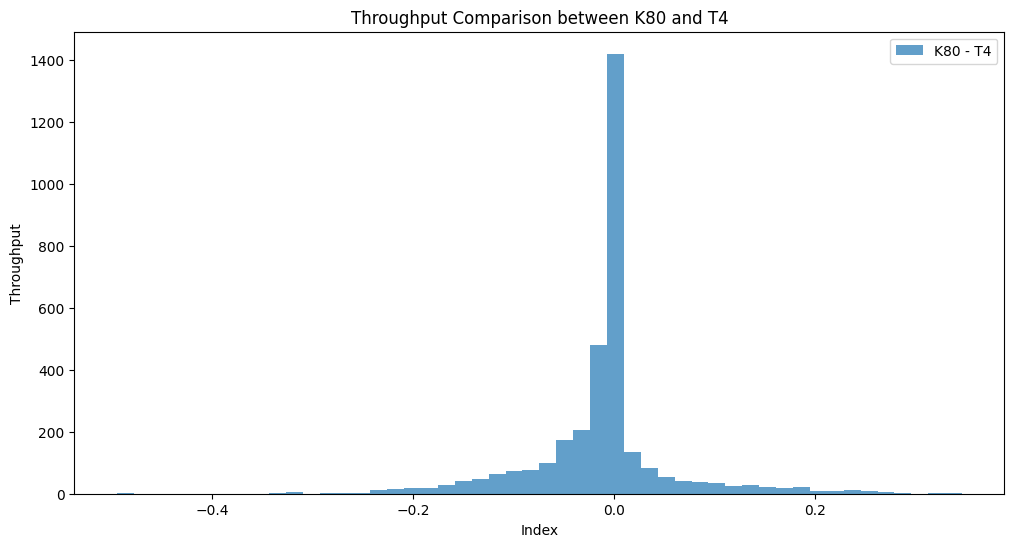

In [36]:
# throughputs_k80, throughputs_t4 점 그래프 그리기
# x축은 인덱스, y축은 throughput
import numpy as np
throughputs_k80 = np.array(throughputs_k80)
throughputs_t4 = np.array(throughputs_t4)

sub = throughputs_k80 - throughputs_t4

# 0.05 이상인 sub 남기기
# sub = sub[np.abs(sub) > 0.1]
# throughputs_k80 = throughputs_k80[np.abs(sub) > 0.05]
# throughputs_t4 = throughputs_t4[np.abs(sub) > 0.05]



import matplotlib.pyplot as plt
# 조금 더 크게
plt.figure(figsize=(12, 6))
# plt.scatter(range(len(sub)), sub, label='K80')
# 히스토그램
plt.hist(sub, bins=50, alpha=0.7, label='K80 - T4')
# plt.scatter(range(len(throughputs_t4)), throughputs_t4, label='T4')
plt.xlabel('Index')
plt.ylabel('Throughput')
plt.title('Throughput Comparison between K80 and T4')
plt.legend()
plt.show()